<a href="https://colab.research.google.com/github/krogul222/Autoencoders/blob/master/DogVariationalAutoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial


In [0]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 18s 0us/step


In [0]:
def grayscale(im):
    return im.mean(3).reshape(im.shape[0], -1)

In [0]:
#n_inputs = 32*32

print(np.shape(x_train))

x_train = grayscale(x_train)/255
x_test = grayscale(x_test)/255

x_train_dog_i = np.where(y_train == 5)[0]
x_test_dog_i = np.where(y_test == 5)[0]

x_train = x_train[x_train_dog_i]
x_test = x_test[x_test_dog_i]

print(np.shape(x_train)) 

(50000, 32, 32, 3)
(5000, 1024)


In [0]:
def plot_image(image, shape=[32, 32], cmap = "Greys_r"):
    plt.imshow(image.reshape(shape), cmap=cmap,interpolation="nearest")
    plt.axis("off")  

In [0]:
# looping through the first 10 test images and printing  them out

for i in range(10):
    plt.subplot(1, 10, i+1)
    plot_image(x_train[i], shape=[32, 32], cmap = "Greys_r")
plt.show()

NameError: ignored

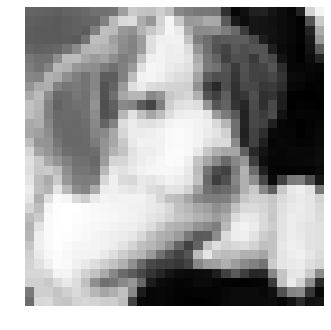

In [0]:
plot_image(x_test[1], shape=[32, 32], cmap = "Greys_r")

In [0]:
def plot_image(image, shape=[32, 32], cmap = "Greys_r"):
    plt.imshow(image.reshape(shape), cmap=cmap,interpolation="nearest")
    plt.axis("off")   

In [0]:
## Parameters

n_inputs = 32*32
BATCH_SIZE = 150

# using a placeholder

#x = tf.placeholder(tf.float32, shape = [None, n_inputs])
x_noisy = tf.placeholder(tf.float32, shape = [None, n_inputs])

## Encoder
n_hidden_1 = 512
n_hidden_2 = 256

## Code
n_hidden_3 = 128

n_latent = 128

## Decodern_hidden_3 = 128


n_hidden_4 = n_hidden_2
n_hidden_5 = n_hidden_1
n_outputs = n_inputs

learning_rate = 0.0001

# using a placeholder
x = tf.placeholder(tf.float32, shape=[None,n_inputs])
batch_size = tf.placeholder(tf.int64)
## Dataset
dataset = tf.data.Dataset.from_tensor_slices(x).repeat().batch(batch_size)
iter = dataset.make_initializable_iterator() # create the iterator
features = iter.get_next()

## Define the Xavier initialization
xav_init =  tf.contrib.layers.xavier_initializer()
## Define the L2 regularizer
l2_reg = 0.001
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

## Create the dense layer
dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.leaky_relu,
                         kernel_initializer=xav_init,
                         kernel_regularizer=l2_regularizer)

# Network architecture

hidden1 = dense_layer(inputs = features, units = n_hidden_1)
hidden2 = dense_layer(inputs = hidden1, units = n_hidden_2)

mn = dense_layer(inputs = hidden2, units=n_latent)
sd = 0.5 * dense_layer(inputs = hidden2, units=n_latent)            
epsilon = tf.random_normal(tf.stack([tf.shape(hidden2)[0], n_latent])) 

z = mn + tf.multiply(epsilon, tf.exp(sd))

#hidden3 = dense_layer(inputs = hidden2, units = n_hidden_3)
hidden4 = dense_layer(inputs = z, units = n_hidden_4)
hidden5 = dense_layer(inputs = hidden4, units = n_hidden_5)
output =  dense_layer(inputs = hidden5, units = n_outputs, activation = tf.nn.sigmoid)

# Loss

img_loss = tf.reduce_sum(tf.squared_difference(output, features), 1)

#img_loss = tf.square(output-features)
#latent_loss = -0.5 * tf.reduce_sum(1.0 + 2.0 * sd - tf.square(mn) - tf.exp(2.0 * sd), 1)
latent_loss = -0.5 * tf.reduce_sum(1 + tf.log(sd) - mn** 2 - sd, 1)
loss = tf.reduce_mean(img_loss+ latent_loss)

#loss=tf.reduce_mean(tf.square(output-features))
optimizer = tf.train.AdamOptimizer(learning_rate)
train  = optimizer.minimize(loss)

num_epoch = 1000

## Call Saver to save the model and re-use it later during evaluation
saver = tf.train.Saver()


with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())
  sess.run(iter.initializer, feed_dict={x: x_train, batch_size: BATCH_SIZE})
  
  print('Training...')
  print(sess.run(features).shape)
  
  for epoch in range(num_epoch):   
    
    num_batches = x_train.shape[0]//BATCH_SIZE

    for iteration in range(num_batches):
      sess.run(train)
    
    train_loss=loss.eval()
    print("epoch {} loss {}".format(epoch,train_loss))
  save_path = saver.save(sess, "./model.ckpt")    
  print("Model saved in path: %s" % save_path)  
  
  
  #num_test_images = 10

  #results = output.eval(feed_dict={x:x_train[:num_test_images]})
    
  #f,a=plt.subplots(2,10,figsize=(20,4))
  #for i in range(num_test_images):
   # a[0][i].imshow(np.reshape( x_train[i],(32,32)), cmap = "Greys_r",interpolation="nearest")
   # a[1][i].imshow(np.reshape(results[i],(32,32)), cmap = "Greys_r",interpolation="nearest")

Training...
(150, 1024)
epoch 0 loss 0.059081241488456726
epoch 1 loss 0.05322908237576485
epoch 2 loss 0.04511801898479462
epoch 3 loss 0.039458438754081726
epoch 4 loss 0.03806702420115471
epoch 5 loss 0.03319423645734787
epoch 6 loss 0.033164653927087784
epoch 7 loss 0.029769230633974075
epoch 8 loss 0.027658220380544662
epoch 9 loss 0.026588795706629753
epoch 10 loss 0.025849921628832817
epoch 11 loss 0.02319634146988392
epoch 12 loss 0.02360379509627819
epoch 13 loss 0.022183774039149284
epoch 14 loss 0.022004880011081696
epoch 15 loss 0.020138908177614212
epoch 16 loss 0.019730478525161743
epoch 17 loss 0.02002502605319023
epoch 18 loss 0.020253151655197144
epoch 19 loss 0.02050328627228737
epoch 20 loss 0.019148562103509903
epoch 21 loss 0.01802530698478222
epoch 22 loss 0.0197722427546978
epoch 23 loss 0.018840253353118896
epoch 24 loss 0.021121952682733536
epoch 25 loss 0.018820377066731453
epoch 26 loss 0.018538033589720726
epoch 27 loss 0.01807769201695919
epoch 28 loss 0.01

In [0]:
def reconstruct_image(df, image_number = 1):
    ## Part 1: Reshape the image to the correct dimension i.e 1, 1024
    x_test = df[image_number]
    x_test_1 = x_test.reshape((1, 32*32))
    
    ## Part 2: Feed the model with the unseen image, encode/decode the image
    with tf.Session() as sess:     
        sess.run(tf.global_variables_initializer()) 
        sess.run(iter.initializer, feed_dict={x: x_test_1,
                                      batch_size: 1})
    ## Part 3:  Print the real and reconstructed image
      # Restore variables from disk.
        saver.restore(sess, "./model.ckpt")  
        print("Model restored.")
      # Reconstruct image
        outputs_val = output.eval()
        print(outputs_val.shape)
        fig = plt.figure()
      # Plot real
        ax1 = fig.add_subplot(121)
        plot_image(x_test_1, shape=[32, 32], cmap = "Greys_r")
      # Plot estimated
        ax2 = fig.add_subplot(122)
        plot_image(outputs_val, shape=[32, 32], cmap = "Greys_r")
        plt.tight_layout()
        fig = plt.gcf()
        
        

INFO:tensorflow:Restoring parameters from ./model.ckpt
Model restored.
(1, 1024)


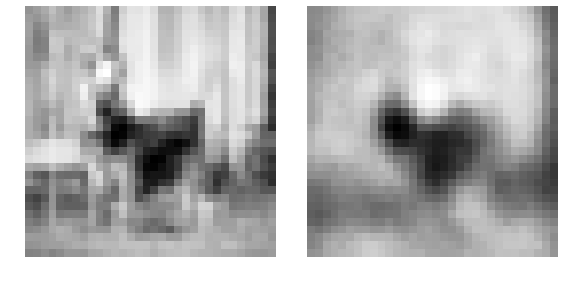

In [0]:
reconstruct_image(df = x_test, image_number = 2)	